In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from model.lstm import LSTM
from model.optimizer import config_optimizer
from model.early_stopping import EarlyStopping
from dataset.normalize import Normalizer
from dataset.preparetion import prepare_data
# from dataset.preparetion_2 import generate_data
from dataset.travel_time_dataset import TravelTimeDataset

In [2]:
cfg = {
    'data': {
        'path': 'E:/data/time_series_clean/start_stop/1.csv',
        'feature': 'delta_t',
        'window_size': 21,
        'train_split_size': 0.6,
        'val_split_size': 0.2,
    },
    'plots': {
        'show_plots': True,
        'color_actual': '#001f3f',
        'color_train': '#3D9970',
        'color_val': '#0074D9',
        'color_test': '#FF4136',
        'color_pred_train': '#3D9970',
        'color_pred_val': '#0074D9',
        'color_pred_test': '#FF4136',
    },
    'model': {
        'input_size': 1,
        'num_lstm_layers': 1,
        'lstm_size': 256,
        'dropout': 0.5,
    },
    'optimizer': {
        'name': 'adam',
        'lr': 0.001,
        'beta': (0.9, 0.999),
        'eps': 1e-8,
        'momentum': 0.9,
        'weight_decay': 1e-6,
    },
    'scheduler': {
        'step_size': 50,
    },
    'train': {
        'device': 'cuda',
        'batch_size': 32,
        'num_epoch': 200,
        'checkpoint_path': 'E:/checkpoints',
    }
}

# Data preparation: load timeseries data of truck travel time each road

In [3]:
def download_data(cfg, plot=False):
    df = pd.read_csv(cfg['data']['path'], index_col=0, parse_dates=True)
    data_date = [date for date in df.index]
    data_date = np.array(data_date)
    data_date = data_date.reshape(-1, 1)

    data_travel_time = [float(df.loc[df.index == date][cfg['data']['feature']]) for date in df.index]
    data_travel_time = np.array(data_travel_time)
    data_travel_time = data_travel_time.reshape(-1, 1)
    
    num_data_points = len(data_date)
    print(f"Number data points: {num_data_points} from {data_date[0][0]} to {data_date[num_data_points - 1][0]}")
    
    if plot:
        road = (cfg['data']['path'].split('/')[-1]).split('.')[0]
        path = cfg['data']['path'].split('/')[-2]
        
        fig = plt.figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_date, data_travel_time, color=cfg['plots']['color_actual']) 
        plt.title(f"Travel time of truck in road {road} and path {path}, from {data_date[0][0]} to {data_date[num_data_points - 1][0]}")
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.show()

    return data_date, data_travel_time, num_data_points

Number data points: 7413 from 2019-01-01 00:00:00 to 2019-12-31 20:00:00


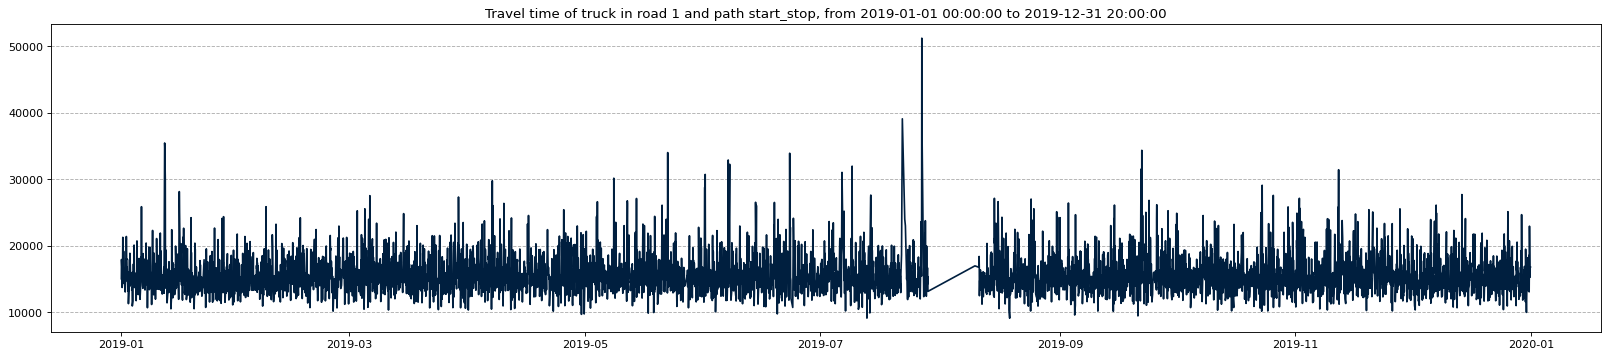

In [4]:
data_date, data_travel_time, num_data_points = download_data(cfg, True)

# Data preparation: normalize raw travel time data

In [5]:
# scaler = MinMaxScaler(feature_range=(-2, 2))
scaler = StandardScaler()
normalize_data_travel_time = scaler.fit_transform(data_travel_time)

# Data preparation: generating training and validation data

In [6]:
def preprocess(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

def generate_data(normalize_data, data_date, num_data_points, scaler, cfg, plot=False):
    # init split index
    split_train_index = int(normalize_data.shape[0] * cfg['data']['train_split_size'])
    split_val_index = int(normalize_data.shape[0] * (cfg['data']['train_split_size'] + cfg['data']['val_split_size']))

    # split data for train test model
    # split data
    data_train = normalize_data[:split_train_index]
    data_val = normalize_data[split_train_index:split_val_index]
    data_test = normalize_data[split_val_index:]

    # split data y
    data_x_train, data_y_train = preprocess(data_train, cfg['data']['window_size'])
    data_x_val, data_y_val = preprocess(data_val, cfg['data']['window_size'])
    data_x_test, data_y_test = preprocess(data_test, cfg['data']['window_size'])

    if plot:
        road = (cfg['data']['path'].split('/')[-1]).split('.')[0]
        path = cfg['data']['path'].split('/')[-2]

        to_plot_data_y_train = np.zeros(num_data_points)
        to_plot_data_y_val = np.zeros(num_data_points)
        to_plot_data_y_test = np.zeros(num_data_points)

        to_plot_data_y_train[:split_train_index] = scaler.inverse_transform(data_train.reshape(1, -1))
        to_plot_data_y_val[split_train_index:split_val_index] = scaler.inverse_transform(data_val.reshape(1, -1))
        to_plot_data_y_test[split_val_index:] = scaler.inverse_transform(data_test.reshape(1, -1))

        to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
        to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
        to_plot_data_y_test = np.where(to_plot_data_y_test == 0, None, to_plot_data_y_test)

        # plot
        fig = plt.figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_date, to_plot_data_y_train, label='travel time (train)', color=cfg['plots']['color_train'])
        plt.plot(data_date, to_plot_data_y_val, label='travel time (validation)', color=cfg['plots']['color_val'])
        plt.plot(data_date, to_plot_data_y_test, label='travel time (test)', color=cfg['plots']['color_test'])

        plt.title(f"Travel time of truck in rode {road} ({path}) - show traning, test and validation data")
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.legend()
        plt.show()

    return data_x_train, data_x_val, data_x_test, data_y_train, data_y_val, data_y_test, split_train_index, split_val_index

In [7]:
# split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen = prepare_data(normalize_data_travel_time, data_date, num_data_points, scaler, cfg, True)

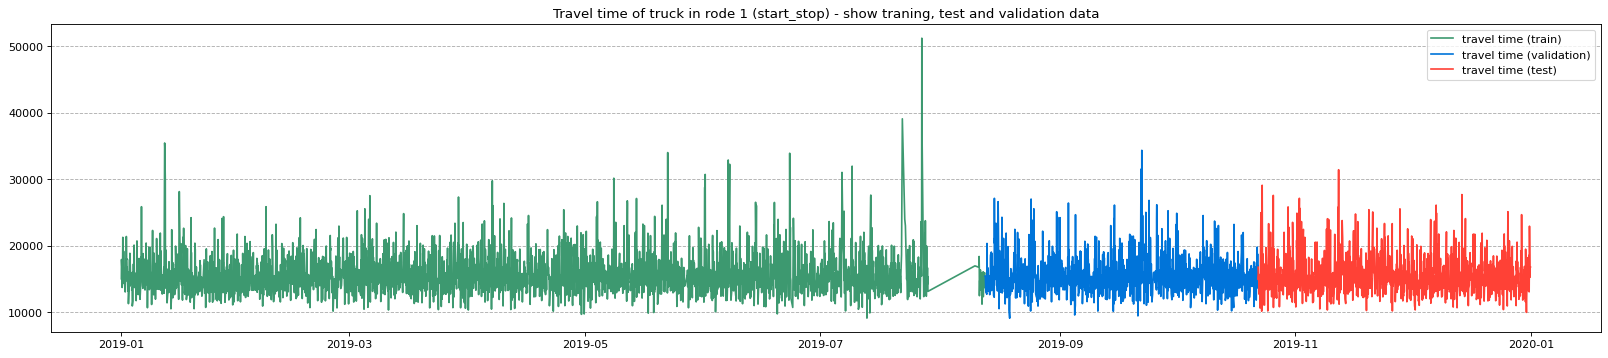

In [8]:
data_x_train, data_x_val, data_x_test, data_y_train, data_y_val, data_y_test, split_train_index, split_val_index = generate_data(normalize_data_travel_time, data_date, num_data_points, scaler, cfg, True)

In [9]:
dataset_train = TravelTimeDataset(data_x_train, data_y_train)
dataset_val = TravelTimeDataset(data_x_val, data_y_val)
dataset_test = TravelTimeDataset(data_x_test, data_y_test)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)
print("Test data shape", dataset_test.x.shape, dataset_test.y.shape)

Train data shape (4426, 21, 1) (4426,)
Validation data shape (1462, 21, 1) (1462,)
Test data shape (1462, 21, 1) (1462,)


# Define LSTM model

In [10]:
class AttentionalLSTM(nn.Module):
    def __init__(self, input_size, qkv, hidden_size, num_layers, output_size, bidirectional=False):
        super(AttentionalLSTM, self).__init__()

        self.input_size = input_size
        self.qkv = qkv
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.query = nn.Linear(input_size, qkv)
        self.key = nn.Linear(input_size, qkv)
        self.value = nn.Linear(input_size, qkv)

        self.attn = nn.Linear(qkv, input_size)
        self.scale = math.sqrt(qkv)

        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=bidirectional)

        self.dropout = nn.Dropout(0.5)
        
        if bidirectional:
            self.fc = nn.Linear(hidden_size * 2, output_size)
        else:
            self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # print(x.shape)
        Q, K, V = self.query(x), self.key(x), self.value(x)

        dot_product = torch.matmul(Q, K.permute(0, 2, 1)) / self.scale
        scores = torch.softmax(dot_product, dim=-1)
        scaled_x = torch.matmul(scores, V) + x

        out = self.attn(scaled_x) + x

        # print(f"out : {out.shape}")

        out, _ = self.lstm(out)
        out = out[:, -1, :]
        out = self.dropout(out)
        # print(out.shape)
        out = self.fc(out)

        return out

In [11]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

In [12]:
# model = LSTM(input_size=cfg['model']['input_size'], hidden_size=cfg['model']['lstm_size'], num_layers=cfg['model']['num_lstm_layers'], output_size=1, dropout=cfg['model']['dropout'])
model = AttentionalLSTM(input_size=1, qkv=cfg['data']['window_size'], hidden_size=256, num_layers=1, output_size=1, bidirectional=False)

In [13]:
# model = LSTM_Model(input_size=cfg['model']['input_size'], hidden_size=cfg['model']['lstm_size'], num_layers=cfg['model']['num_lstm_layers'], output_size=1, dropout=cfg['model']['dropout'])
model.apply(init_weights)
if torch.cuda.is_available():
    cfg['train']['device'] = 'cuda'
else:
    cfg['train']['device'] = 'cpu'
print(f"Training model use the {cfg['train']['device']}")
model = model.to(cfg['train']['device'])

Training model use the cpu


# Model training

In [14]:
# init tool for train model
# craete dataloader
train_dataloader = DataLoader(dataset_train, batch_size=cfg['train']['batch_size'], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=cfg['train']['batch_size'], shuffle=True)

# define optimizer, sheduler and loss function
criterion = nn.MSELoss()
optimizer = config_optimizer(cfg, model.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=cfg['scheduler']['step_size'], gamma=0.5)
early_stopping = EarlyStopping(patience=20, verbose=True, path=cfg['train']['checkpoint_path'], delta=0.001)

Using [adam]: learning rate = 0.001, weight_decay = 1e-06


In [15]:
train_losses = []
valid_losses = []
avg_train_losses = []
avg_valid_losses = []

In [16]:
for epoch in range(cfg['train']['num_epoch']):
    print(f"Epoch: {epoch + 1}")

    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (x, y) in enumerate(train_dataloader):
        batch_size = x.shape[0]

        x = x.to(cfg['train']['device'])
        y = y.to(cfg['train']['device'])

        # prediction
        pred = model(x)
        loss = criterion(pred[:,0], y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # add train loss
        train_losses.append(loss.item())

    ######################    
    # validate the model #
    ######################
    model.eval()
    for batch_idx, (x, y) in enumerate(val_dataloader):
        batch_size = x.shape[0]

        x = x.to(cfg['train']['device'])
        y = y.to(cfg['train']['device'])

        pred = model(x)
        loss = criterion(pred[:,0], y)

        # add valid loss
        valid_losses.append(loss.item())

    # update scheduler
    lr = scheduler.get_last_lr()[0]
    scheduler.step()

    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)

    print(f"[Epoch: {epoch + 1} / {cfg['train']['num_epoch']} || train_loss: {train_loss:.5f} || valid_loss: {valid_loss:.5f} || lr: {lr:.5f}]")

    train_losses = []
    valid_losses = []

    early_stopping(valid_loss, epoch, model, cfg)

    if early_stopping.early_stop:
        print('Early stopping')
        break
    

Epoch: 1
[Epoch: 1 / 200 || train_loss: 0.89353 || valid_loss: 0.81170 || lr: 0.00100]
Validation loss decreased (inf --> 0.811696). Saving model ...
Epoch: 2
[Epoch: 2 / 200 || train_loss: 0.80828 || valid_loss: 0.79843 || lr: 0.00100]
Validation loss decreased (0.811696 --> 0.798435). Saving model ...
Epoch: 3
[Epoch: 3 / 200 || train_loss: 0.79231 || valid_loss: 0.80358 || lr: 0.00100]
EarlyStopping counter: 1 out of 20
Epoch: 4
[Epoch: 4 / 200 || train_loss: 0.79067 || valid_loss: 0.78657 || lr: 0.00100]
Validation loss decreased (0.798435 --> 0.786573). Saving model ...
Epoch: 5
[Epoch: 5 / 200 || train_loss: 0.80324 || valid_loss: 0.78247 || lr: 0.00100]
Validation loss decreased (0.786573 --> 0.782473). Saving model ...
Epoch: 6
[Epoch: 6 / 200 || train_loss: 0.77782 || valid_loss: 0.79866 || lr: 0.00100]
EarlyStopping counter: 1 out of 20
Epoch: 7
[Epoch: 7 / 200 || train_loss: 0.77457 || valid_loss: 0.79267 || lr: 0.00100]
EarlyStopping counter: 2 out of 20
Epoch: 8
[Epoch: 8 

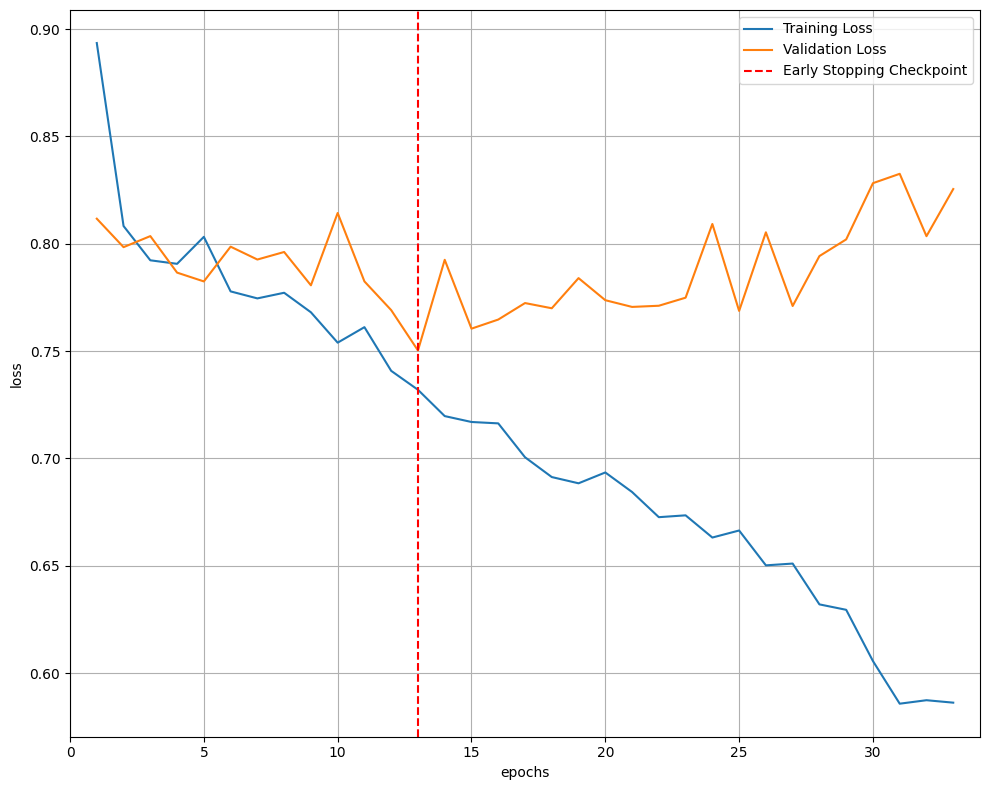

In [17]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1, len(avg_train_losses) + 1), avg_train_losses, label='Training Loss')
plt.plot(range(1, len(avg_valid_losses) + 1), avg_valid_losses,label='Validation Loss')

# find position of lowest validation loss
minposs = np.where(avg_valid_losses == early_stopping.val_loss_min)[0] + 1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
# plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(avg_train_losses)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Model evaluation

In [21]:
train_dataloader = DataLoader(dataset_train, batch_size=cfg['train']['batch_size'], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=cfg['train']['batch_size'], shuffle=False)
test_dataloader = DataLoader(dataset_test, batch_size=cfg['train']['batch_size'], shuffle=False)

In [22]:
checkpoint = torch.load(os.path.join(cfg['train']['checkpoint_path'],'lstm_13_0.750.pth'))
model.load_state_dict(checkpoint['net'])

<All keys matched successfully>

MSE : 6546947.203367549
RMSE : 2558.7002957297577
MAE : 1876.4900455449354


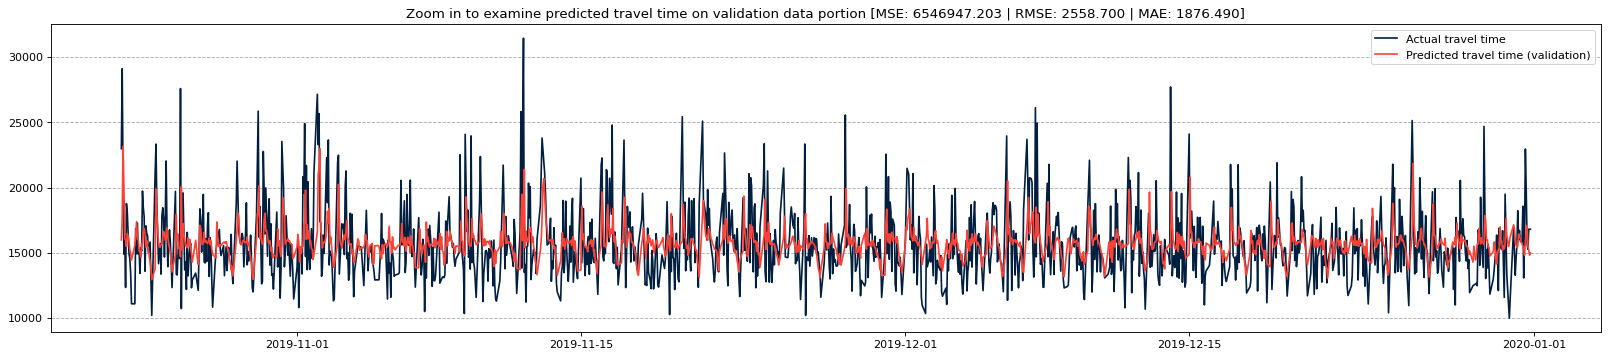

In [23]:
predicted_train = np.array([])
predicted_val = np.array([])
predicted_test = np.array([])

all_data_popint = len(dataset_train.x) + len(dataset_val.x) + len(dataset_test.x)

model.eval()
for batch_idx, (x, y) in enumerate(train_dataloader):
    x = x.to(cfg['train']['device'])
    pred = model(x)
    pred = pred.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, pred[:, 0]))

for batch_idx, (x, y) in enumerate(val_dataloader):
    x = x.to(cfg['train']['device'])
    pred = model(x)
    pred = pred.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, pred[:, 0]))

for batch_idx, (x, y) in enumerate(test_dataloader):
    x = x.to(cfg['train']['device'])
    pred = model(x)
    pred = pred.cpu().detach().numpy()
    predicted_test = np.concatenate((predicted_test, pred[:, 0]))

mse = mean_squared_error(scaler.inverse_transform(data_y_test.reshape(-1, 1)), scaler.inverse_transform(predicted_test.reshape(-1, 1)))
rmse = math.sqrt(mean_squared_error(scaler.inverse_transform(data_y_test.reshape(-1, 1)), scaler.inverse_transform(predicted_test.reshape(-1, 1))))
mae = mean_absolute_error(scaler.inverse_transform(data_y_test.reshape(-1, 1)), scaler.inverse_transform(predicted_test.reshape(-1, 1)))

print(f"MSE : {mse}")
print(f"RMSE : {rmse}")
print(f"MAE : {mae}")

if cfg['plots']['show_plots']:
    to_plot_data_y_train_pred = np.zeros(all_data_popint)
    to_plot_data_y_val_pred = np.zeros(all_data_popint)
    to_plot_data_y_test_pred = np.zeros(all_data_popint)

    to_plot_data_y_train_pred[:len(dataset_train.x)] = scaler.inverse_transform(predicted_train.reshape(1, -1))
    to_plot_data_y_val_pred[len(dataset_train.x):len(dataset_train.x) + len(dataset_val.x)] = scaler.inverse_transform(predicted_val.reshape(1, -1))
    to_plot_data_y_test_pred[len(dataset_train.x) + len(dataset_val.x):] = scaler.inverse_transform(predicted_test.reshape(1, -1))

    to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
    to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)


    # idx = np.arange(0, all_data_popint)

    # # plot
    # fig = plt.figure(figsize=(25, 5), dpi=80)
    # fig.patch.set_facecolor((1.0, 1.0, 1.0))
    # # plt.plot(idx, data_travel_time, label='Actual travel time', color=cfg['plots']['color_actual'])
    # plt.plot(idx, to_plot_data_y_train_pred, label='Predicted travel time (train)', color=cfg['plots']['color_pred_train'])
    # plt.plot(idx, to_plot_data_y_val_pred, label='Predicted travel time (validation)', color=cfg['plots']['color_pred_val'])
    # plt.plot(idx, to_plot_data_y_test_pred, label='Predicted travel time (test)', color=cfg['plots']['color_pred_test'])
    # plt.title(f"Compare predicted travel time to actual travel time")
    # plt.grid(b=None, which='major', axis='y', linestyle='--')
    # plt.legend()
    # plt.show()

    # prepare data for plotting, zoom in validation
    to_plot_data_y_val_subset = scaler.inverse_transform(data_y_test.reshape(-1, 1))
    to_plot_predicted_val = scaler.inverse_transform(predicted_test.reshape(-1, 1))
    to_plot_data_date = data_date[split_val_index + cfg['data']['window_size']:]

    #plot
    fig = plt.figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label='Actual travel time', color=cfg['plots']['color_actual'])
    plt.plot(to_plot_data_date, to_plot_predicted_val, label='Predicted travel time (validation)', color=cfg['plots']['color_pred_test'])
    plt.title(f"Zoom in to examine predicted travel time on validation data portion [MSE: {mse:.3f} | RMSE: {rmse:.3f} | MAE: {mae:.3f}]")
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()